<a href="https://colab.research.google.com/github/cubukcum/road_segmentation_unet/blob/main/Road_Segmentation_UNet_Multiclass_Comma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
import cv2
import random
from tqdm import tqdm

In [ ]:
!unzip /content/drive/MyDrive/comma.zip

Streaming output truncated to the last 5000 lines.
  inflating: comma10k/masks/4888_088376fd1d121661_2018-05-19--15-39-25_20_1129.png  
  inflating: comma10k/masks/4889_ef53f1ffea65e93c_2018-10-11--18-51-43_6_780.png  
  inflating: comma10k/masks/4890_5948c4bc4f870bc7_2018-06-17--17-22-44_26_692.png  
  inflating: comma10k/masks/4891_a8c2c0db11b57616_2018-08-06--20-22-34_23_591.png  
  inflating: comma10k/masks/4892_aee00e7a217cbe97_2018-09-22--14-19-14_7_588.png  
  inflating: comma10k/masks/4893_92c1e126f0e52b85_2018-06-16--16-15-03_11_319.png  
  inflating: comma10k/masks/4894_3dad3b1439b2aa5c_2018-06-27--04-16-03_8_385.png  
  inflating: comma10k/masks/4895_2a6d6ba03fb9c4dc_2018-05-06--10-35-56_17_899.png  
  inflating: comma10k/masks/4896_e16fb3d63e3ed6cc_2018-06-27--22-07-21_34_1087.png  
  inflating: comma10k/masks/4897_4ea7f6e00a335885_2018-06-20--21-29-23_30_1198.png  
  inflating: comma10k/masks/4898_fa9156edb12b0716_2018-11-05--07-23-57_8_551.png  
  inflating: comma10k/mask

In [ ]:
Road = np.array([64, 42, 42])
Lane = np.array([255,0,0])
Undrivable = np.array([128,128,96])
Movable = np.array([0,255,102])
Car = np.array([204,0,255])

def set_labels(mask_dataset):
    labels = []
    for i in range(mask_dataset.shape[0]):
        label = rgb_to_2D_label(mask_dataset[i])
        labels.append(label)
    labels = np.array(labels)
    labels = np.expand_dims(labels, axis=3)

    print("Unique labels in label dataset are: ", np.unique(labels))
    n_classes = len(np.unique(labels))
    from tensorflow.keras.utils import to_categorical
    labels_cat = to_categorical(labels, num_classes=n_classes)


    return labels_cat

def rgb_to_2D_label(label):

    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg[np.all(label == Road, axis=-1)] = 0
    label_seg[np.all(label == Lane, axis=-1)] = 1
    label_seg[np.all(label == Undrivable, axis=-1)] = 2
    label_seg[np.all(label == Movable, axis=-1)] = 3
    label_seg[np.all(label == Car, axis=-1)] = 4

    label_seg = label_seg[:, :, 0]  # Just take the first channel, no need for all 3 channels

    return label_seg

In [ ]:
# strategy = tf.distribute.MirroredStrategy()
np.random.seed(42)
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

TRAIN_PATH = "/content/comma10k/imgs"
TRAIN_MASKS_PATH = "/content/comma10k/masks"


# TRAIN_PATH = "/kaggle/input/commaai2000/comma_dataset_max/train_images"
# TRAIN_MASKS_PATH = '/kaggle/input/commaai2000/comma_dataset_max/train_masks'
# TEST_PATH = '/kaggle/input/commaai/comma_dataset/comma_dataset/test_images'
# TEST_MASKS_PATH = '/kaggle/input/commaai/comma_dataset/comma_dataset/test_masks'

train_image_files = os.listdir(TRAIN_PATH)
train_mask_files = os.listdir(TRAIN_MASKS_PATH)
# test_image_files = os.listdir(TEST_PATH)
# test_mask_files = os.listdir(TEST_MASKS_PATH)

numberOfClasses = 5

X_train = np.zeros((len(train_image_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_image_files), IMG_HEIGHT, IMG_WIDTH, numberOfClasses), dtype=np.uint8)


images = []
masks = []
for n, image_file in tqdm(enumerate(train_image_files), total=len(train_image_files), desc="Train images..."):
    if os.path.splitext(image_file)[1].lower() == ".png":
      image_path = os.path.join(TRAIN_PATH, image_file)
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (IMG_HEIGHT,IMG_WIDTH))
      image = image / 255

      images.append(image)

for n, mask_file in tqdm(enumerate(train_mask_files), total=len(train_mask_files), desc="Train masks..."):
    if os.path.splitext(mask_file)[1].lower() == ".png":
      mask_path = os.path.join(TRAIN_MASKS_PATH, mask_file)
      mask = cv2.imread(mask_path)
      mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
      mask = cv2.resize(mask, (IMG_HEIGHT,IMG_WIDTH))

      masks.append(mask)


X_train, Y_train = np.array(images), np.array(masks)
del images
del masks


Y_train = set_labels(Y_train)

Train masks...: 100%|██████████| 9888/9888 [01:58<00:00, 83.72it/s]


Unique labels in label dataset are:  [0 1 2 3 4]


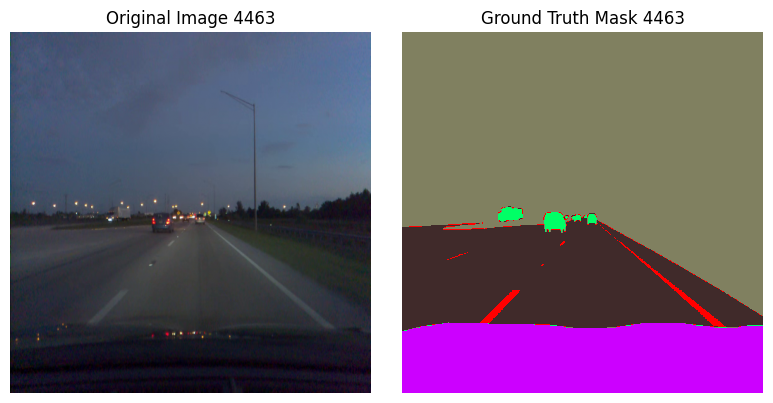

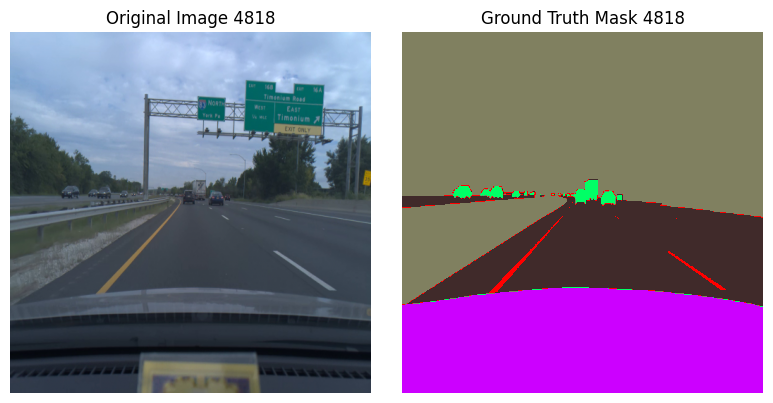

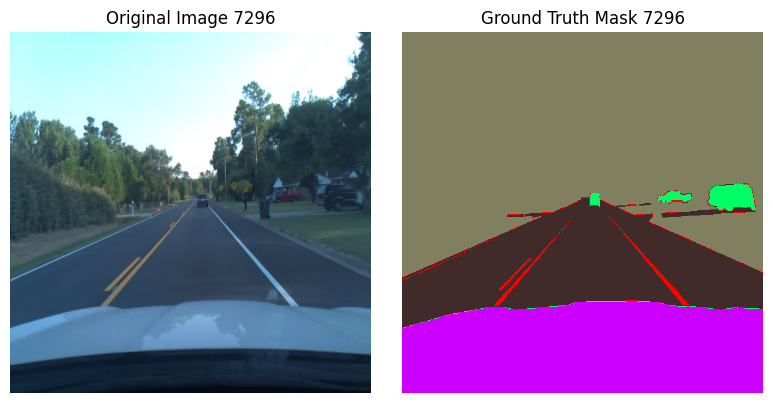

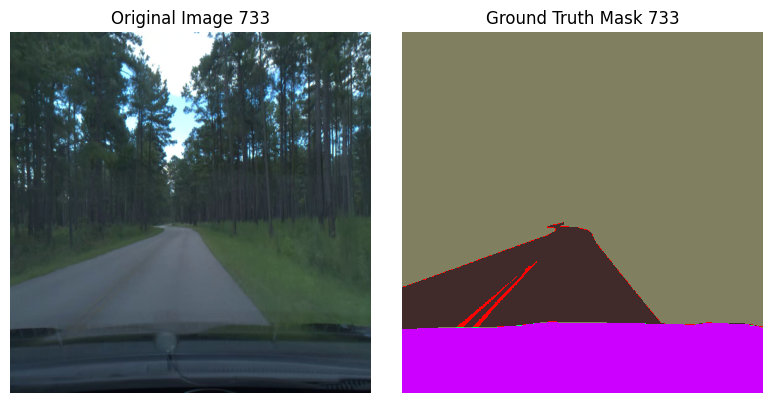

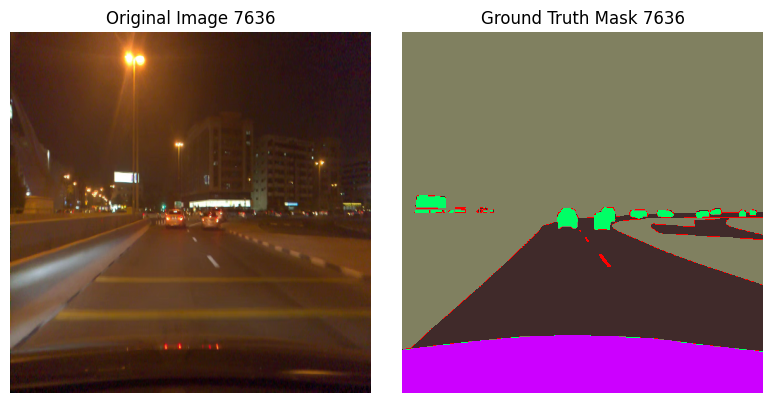

In [ ]:
num_images_to_display = 5

selected_indices = np.random.choice(len(X_train), num_images_to_display, replace=False)

colors = [ Road / 255.0,Lane / 255.0,Undrivable / 255.0,  Movable / 255.0, Car / 255.0]
cmap = ListedColormap(colors)


for i, idx in enumerate(selected_indices):
    plt.figure(figsize=(8, 4))

    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(X_train[idx])
    plt.title(f"Original Image {idx}")
    plt.axis('off')

    # Display the corresponding mask with the custom colormap
    plt.subplot(1, 2, 2)

    # Convert one-hot encoded mask to integer labels
    mask_labels = np.argmax(Y_train[idx], axis=-1)

    # Display the mask using the custom colormap
    plt.imshow(mask_labels, cmap=cmap, vmin=0, vmax=4)
    plt.title(f"Ground Truth Mask {idx}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [11]:
print(Y_train.shape)
print(X_train.shape)

(9888, 512, 512, 5)
(9888, 512, 512, 3)


In [ ]:
def create_unet_model(numberOfClasses = 5, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    # Build the model
    inputs = tf.keras.layers.Input(input_shape)
    s = inputs

    # Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(numberOfClasses, (1, 1), activation='softmax')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
#tf.compat.v1.disable_eager_execution()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# with strategy.scope():
#     model = create_unet_model(numberOfClasses = 5)
#     #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model = create_unet_model(numberOfClasses = 5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#print(np.min(Y_train), np.max(Y_train))
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
        tf.keras.callbacks.ModelCheckpoint('model_for_lane.h5', verbose=1, save_best_only=True)]

results = model.fit(X_train, Y_train, batch_size=16, epochs=50,steps_per_epoch=62,validation_split=0.1, callbacks=callbacks)

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 1.0810 - accuracy: 0.5200
Epoch 1: val_loss improved from inf to 0.93255, saving model to model_for_lane.h5
62/62 [==============================] - 464s 7s/step - loss: 1.0810 - accuracy: 0.5200 - val_loss: 0.9326 - val_accuracy: 0.5635
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


62/62 [==============================] - ETA: 0s - loss: 0.7158 - accuracy: 0.7197
Epoch 2: val_loss improved from 0.93255 to 0.60875, saving model to model_for_lane.h5
62/62 [==============================] - 450s 7s/step - loss: 0.7158 - accuracy: 0.7197 - val_loss: 0.6087 - val_accuracy: 0.7468
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 0.5119 - accuracy: 0.8240
Epoch 3: val_loss improved from 0.60875 to 0.48259, saving model to model_for_lane.h5
62/62 [==============================] - 453s 7s/step - loss: 0.5119 - accuracy: 0.8240 - val_loss: 0.4826 - val_accuracy: 0.8265
Epoch 4/50
62/62 [==============================] - ETA: 0s - loss: 0.4341 - accuracy: 0.8572
Epoch 4: val_loss improved from 0.48259 to 0.45444, saving model to model_for_lane.h5
62/62 [==============================] - 454s 7s/step - loss: 0.4341 - accuracy: 0.8572 - val_loss: 0.4544 - val_accuracy: 0.8463
Epoch 5/50
62/62 [==============================] - ETA: 0s - loss: 0.3771 - accu

In [ ]:
tf.saved_model.save(model,"/content/" )


In [ ]:
import tensorflow as tf
#/content/drive/MyDrive
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("/content/") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('/content/drive/MyDrive/model.tflite', 'wb') as f:
  f.write(tflite_model)